In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import logging

# 로거 생성 및 설정
logger = logging.getLogger()  # 기본 로거 가져오기
logger.setLevel(logging.INFO)  # 로그 수준 설정

# Jupyter Notebook에 출력될 수 있도록 스트림 핸들러 추가
if not logger.handlers:
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s\n%(message)s')
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

# library

In [3]:
# Standard Library Imports
import os
import json
import shutil
import pickle
from time import strftime
from io import BytesIO

# Third-Party Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl  # rcParams 설정을 위해 필요
from matplotlib import font_manager, rc
import joblib
import shap
import lightgbm as lgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_squared_log_error, 
    explained_variance_score, 
    median_absolute_error
)

# Boto3 Imports
import boto3
from botocore.exceptions import ClientError

# InterpretML Imports
from interpret import show, set_visualize_provider
from interpret.provider import InlineProvider
from interpret.perf import RegressionPerf
from interpret.glassbox import ExplainableBoostingRegressor, RegressionTree
from interpret.data import Marginal

# Wandb Imports
import wandb
from wandb.integration.lightgbm import wandb_callback, log_summary

# Custom Imports
import utils
import prep
import modeling as m
import metric

# pp
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Set pandas display options
pd.set_option('display.max_columns', None)

# Set visualization provider for interpret
set_visualize_provider(InlineProvider())

# chart font setup

In [4]:
!cat /sys/class/dmi/id/product_name

t3.medium


In [5]:
import os
import subprocess


def is_sagemaker_instance():
    try:
        # SageMaker 인스턴스 여부 확인
        with open("/sys/class/dmi/id/product_name", "r") as f:
            return "t3.medium" in f.read()
    except FileNotFoundError:
        return False

def install_font():
    with open(os.devnull, 'w') as devnull:
        # SageMaker 노트북에서 한글 폰트 설치
        subprocess.call("sudo yum install -y fontconfig", shell=True, stdout=devnull, stderr=devnull)
        subprocess.call("wget https://hangeul.pstatic.net/hangeul_static/webfont/NanumGothic/NanumGothic.ttf", shell=True, stdout=devnull, stderr=devnull)
        subprocess.call("sudo mkdir -p /usr/share/fonts/nanum/", shell=True, stdout=devnull, stderr=devnull)
        subprocess.call("sudo mv NanumGothic.ttf /usr/share/fonts/nanum/", shell=True, stdout=devnull, stderr=devnull)
        subprocess.call("fc-cache -fv", shell=True, stdout=devnull, stderr=devnull)

# SageMaker 인스턴스에서만 실행
if is_sagemaker_instance():
    install_font()
    logger.info("Font installed successfully on SageMaker Notebook Instance.")
else:
    logger.info("This is not a SageMaker Notebook Instance. Skipping font installation.")

2024-11-07 06:43:58,023 - INFO
Font installed successfully on SageMaker Notebook Instance.


In [6]:
# 한글 폰트 설정
font_path = '/usr/share/fonts/nanum/NanumGothic.ttf'
font_manager.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

# load config and pickle df

In [7]:
local_folder = 'input'

In [8]:
# should be removed
config_file = './input/config.yml'
pickle_file = './input/df.pickle'

In [9]:
conf = utils.load_yaml(config_file)
df = pd.read_pickle(pickle_file)

In [10]:
logger.info(f'df.shape: {df.shape}')

2024-11-07 06:43:58,284 - INFO
df.shape: (6497, 12)


In [11]:
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [12]:
target_col = conf['FEATURES']['target_col']
feature_cols = conf['FEATURES']['feature_cols']
index_col = conf['FEATURES']['index_col']['col_name']
index_col_dtype = conf['FEATURES']['index_col']['col_dtype']
SEED = conf['SEED']

In [13]:
df = prep.filter_missing_values(df, target_col)

In [14]:
logger.info(f'df.shape: {df.shape}')

2024-11-07 06:43:58,461 - INFO
df.shape: (6497, 12)


In [15]:
logger.info("conf:\n%s", pp.pformat(conf))

2024-11-07 06:43:58,492 - INFO
conf:
{   'BOOSTING': {'early_stopping_rounds': 50, 'num_boost_round': 1000},
    'EBM_BOOSTING': {'early_stopping_rounds': 50, 'max_rounds': 1000},
    'FEATURES': {   'feature_cols': [   'fixed_acidity',
                                        'volatile_acidity',
                                        'citric_acid',
                                        'residual_sugar',
                                        'chlorides',
                                        'free_sulfur_dioxide',
                                        'total_sulfur_dioxide',
                                        'density',
                                        'pH',
                                        'sulphates',
                                        'alcohol'],
                    'index_col': {'col_dtype': 'float', 'col_name': 'alcohol'},
                    'target_col': 'quality'},
    'HYPERPARAMS': {   'bagging_fraction': 0.8,
                       'bagging_fr

# prep dataset

In [16]:
df = prep.convert_column_type(df, index_col, index_col_dtype)

In [17]:
data_df = df.copy(deep=True)

In [18]:
# Train & Validation 데이터프레임 생성
if conf['SPLIT']['type'] == 'chronological':
    train_df, valid_df, test_df = prep.split_train_test_chronologically(df, 
                                                    datetime_column=conf['SPLIT']['chronological_split_colname'], 
                                                    valid_size=conf['SPLIT']['valid_size'],
                                                    test_size=conf['SPLIT']['test_size']
                                                    )
elif conf['SPLIT']['type'] == 'random':
    train_df, valid_df, test_df = prep.split_train_test_randomly(df, 
                                                    target_col=conf['FEATURES']['target_col'], 
                                                    seed=conf['SEED'], 
                                                    valid_size=conf['SPLIT']['valid_size'],
                                                    test_size=conf['SPLIT']['test_size']
                                                    )
elif conf['SPLIT']['type'] == 'manual':
    train_df, valid_df, test_df = prep.split_train_test_randomly(df, 
                                                    type_col=conf['SPLIT']['manual_split_colname']
                                                    )

In [19]:
logger.info(f'''
df.shape: {df.shape}, 
data_df.shape: {data_df.shape}, 
train_df.shape: {train_df.shape}, 
valid_df.shape: {valid_df.shape}, 
test_df.shape: {test_df.shape}
''')

2024-11-07 06:43:58,642 - INFO

df.shape: (6497, 12), 
data_df.shape: (6497, 12), 
train_df.shape: (5262, 12), 
valid_df.shape: (585, 12), 
test_df.shape: (650, 12)



# modeling

In [20]:
params = conf['HYPERPARAMS']
boosting = conf['BOOSTING']

model = m.train_lgbm_model(train_df, valid_df, target_col, feature_cols, params, boosting)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 5262, number of used features: 11
[LightGBM] [Info] Start training from score 5.809768
Training until validation scores don't improve for 50 rounds


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[200]	validation's rmse: 0.652749	validation's l2: 0.426082	validation's l1: 0.47421	validation's huber: 0.186865


# feature 중요도

In [21]:
importance_gain_df = m.create_feature_importance_df(model, feature_cols, importance_type='gain')
importance_split_df = m.create_feature_importance_df(model, feature_cols, importance_type='split')

In [22]:
max_features=20

In [23]:
# 결합된 피처 중요도 계산
final_importance_df = m.combine_feature_importance(importance_gain_df, importance_split_df)

# 상위 20개 피처 출력
logger.info(final_importance_df.head(max_features))

2024-11-07 06:43:59,789 - INFO
                 Feature  Final_Importance  Gain_Importance  Split_Importance
0                alcohol          0.138480         0.205781          0.071180
1       volatile_acidity          0.107697         0.127276          0.088119
3   total_sulfur_dioxide          0.096441         0.082158          0.110724
2                density          0.095149         0.092499          0.097799
5    free_sulfur_dioxide          0.089328         0.081566          0.097090
6         residual_sugar          0.087150         0.078391          0.095910
4              sulphates          0.085683         0.082067          0.089299
7                     pH          0.080211         0.067405          0.093018
9              chlorides          0.079859         0.064989          0.094729
8            citric_acid          0.076409         0.066175          0.086643
10         fixed_acidity          0.063591         0.051694          0.075488


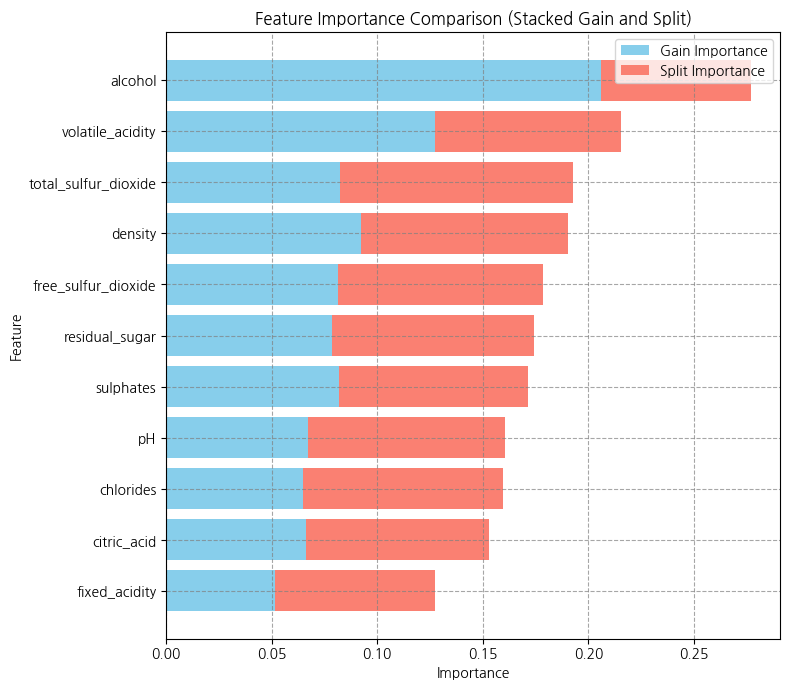

In [24]:
m.plot_feature_importance(final_importance_df)

In [25]:
important_feature_cols = final_importance_df['Feature'][:max_features].to_list()

In [26]:
logger.info("중요 피쳐들:\n%s", pp.pformat(important_feature_cols))

2024-11-07 06:44:00,739 - INFO
중요 피쳐들:
[   'alcohol',
    'volatile_acidity',
    'total_sulfur_dioxide',
    'density',
    'free_sulfur_dioxide',
    'residual_sugar',
    'sulphates',
    'pH',
    'chlorides',
    'citric_acid',
    'fixed_acidity']


# metric 계산

In [27]:
logging.getLogger('metric').setLevel(logging.WARNING)

In [28]:
folder_path = 'artifacts/metric_images'
utils.create_clean_folder(folder_path)

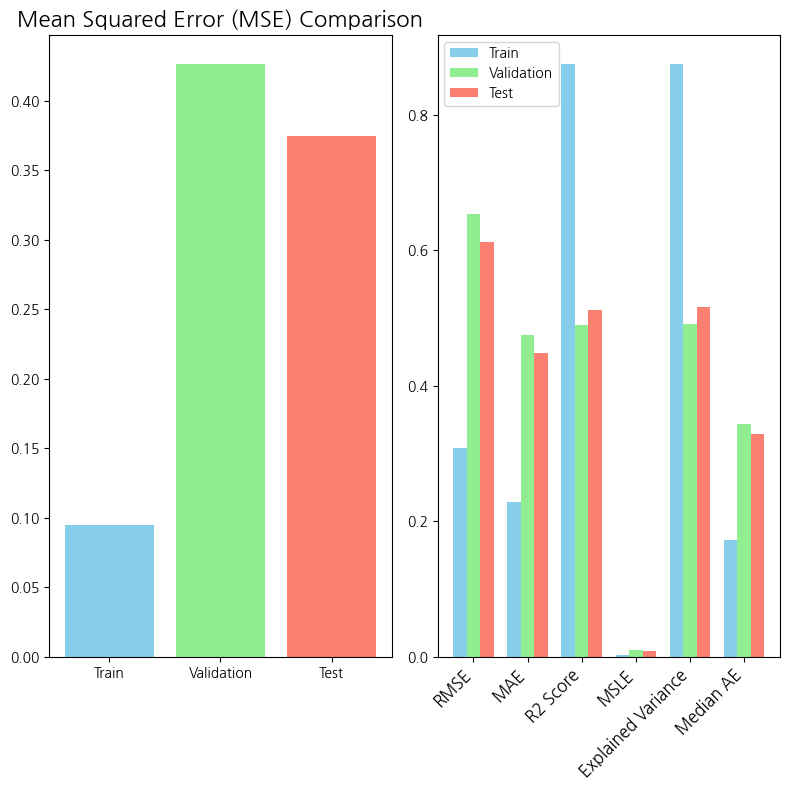

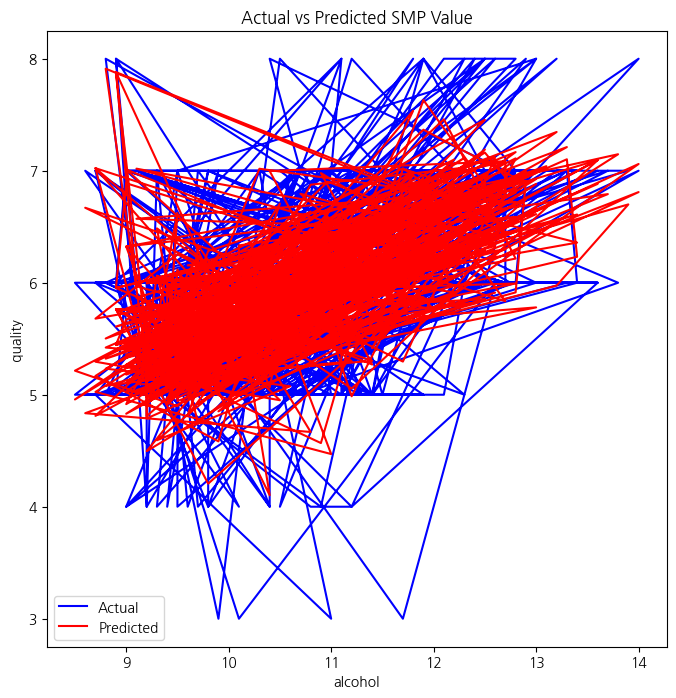

In [29]:
metric_res = metric.run_evaluation(train_df, valid_df, test_df, model, index_col, target_col, feature_cols, folder_path)

In [30]:
metric_df = pd.DataFrame(metric_res)
logger.info(metric_df)

2024-11-07 06:44:02,568 - INFO
                    train_metrics  valid_metric  test_metric
MSE                      0.094917      0.426082     0.374782
RMSE                     0.308086      0.652749     0.612195
MAE                      0.228928      0.474210     0.448058
R2 Score                 0.873958      0.489451     0.512099
MSLE                     0.002265      0.009457     0.008654
Explained Variance       0.873958      0.490310     0.515695
Median AE                0.172954      0.344093     0.328384


In [31]:
# raise KeyboardInterrupt("Execution stopped intentionally.")  # 이 지점에서 실행이 멈춤

# EBM Modeling
* https://interpret.ml/docs/python/api/ExplainableBoostingRegressor.html

In [32]:
%%time
# 아래와 같이 쓰면 interpret 패키지에서 사용하는 logger 를 가져오게 된다 
# -> 즉, 불필요한 로그를 제거하고 싶었음
logging.getLogger('interpret').setLevel(logging.WARNING)

ebm = ExplainableBoostingRegressor(
    random_state=SEED,
    max_rounds=conf['EBM_BOOSTING']['max_rounds'],
    early_stopping_rounds=conf['EBM_BOOSTING']['early_stopping_rounds'],
)
ebm.fit(train_df[feature_cols], train_df[target_col])

CPU times: user 35.5 s, sys: 14.4 ms, total: 35.5 s
Wall time: 41.3 s


ExplainableBoostingRegressor(early_stopping_rounds=50, max_rounds=1000,
                             random_state=2024)

In [33]:
%%time
ebm_global = ebm.explain_global(name='EBM')
# show(ebm_global)

CPU times: user 5.76 ms, sys: 28 μs, total: 5.78 ms
Wall time: 5.04 ms


In [34]:
# 만들고자 하는 폴더 경로
folder_path = 'artifacts/ebm_images'
utils.create_clean_folder(folder_path)

In [35]:
ebm_global.feature_names

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'fixed_acidity & pH',
 'volatile_acidity & residual_sugar',
 'volatile_acidity & density',
 'volatile_acidity & alcohol',
 'chlorides & free_sulfur_dioxide',
 'chlorides & total_sulfur_dioxide',
 'free_sulfur_dioxide & density',
 'free_sulfur_dioxide & sulphates',
 'total_sulfur_dioxide & density',
 'total_sulfur_dioxide & sulphates']

In [36]:
%%time
# ebm_global = ebm.explain_global()
for index, col_name in enumerate(ebm_global.feature_names):
    if col_name in important_feature_cols:
        plotly_fig = ebm_global.visualize(index)
        plotly_fig['layout']['yaxis'].update(autorange = True)
        plotly_fig['layout']['width'] = 800
        plotly_fig['layout']['height'] = 800
        plotly_fig.write_image(f"{folder_path}/fig_{col_name}.png")

CPU times: user 482 ms, sys: 19.9 ms, total: 502 ms
Wall time: 2.99 s


In [37]:
# from interpret import show
# from interpret.data import Marginal

# marginal = Marginal(feature_cols).explain_data(train_df[feature_cols], train_df[target_col], name='Train Data')
# show(marginal)

In [38]:
# ebm_local = ebm.explain_local(train_df[feature_cols][:5], train_df[target_col][:5], name='EBM')
# show(ebm_local, 0)

# EBM - Smoothing Modeling

In [39]:
%%time
ebm_smooth = ExplainableBoostingRegressor(
    interactions=3, 
    smoothing_rounds=5000, 
    cyclic_progress=0.0, 
    reg_alpha=10.0,
    random_state=SEED,
    max_rounds=conf['EBM_BOOSTING']['max_rounds'],
    early_stopping_rounds=conf['EBM_BOOSTING']['early_stopping_rounds']
)
ebm_smooth.fit(train_df[feature_cols], train_df[target_col])

CPU times: user 23.4 s, sys: 16.2 ms, total: 23.4 s
Wall time: 29.8 s


ExplainableBoostingRegressor(cyclic_progress=0.0, early_stopping_rounds=50,
                             interactions=3, max_rounds=1000, random_state=2024,
                             reg_alpha=10.0, smoothing_rounds=5000)

In [40]:
%%time
ebm_smooth_global = ebm_smooth.explain_global()
# show(ebm_smooth_global, 0)

CPU times: user 5.65 ms, sys: 0 ns, total: 5.65 ms
Wall time: 4.91 ms


In [41]:
%%time
# 만들고자 하는 폴더 경로
folder_path = 'artifacts/smooth_ebm_images'
utils.create_clean_folder(folder_path)

########################################################
# save images
for index, col_name in enumerate(ebm_smooth_global.feature_names):
    if col_name in important_feature_cols:
        plotly_fig = ebm_smooth_global.visualize(index)
        plotly_fig['layout']['yaxis'].update(autorange = True)
        plotly_fig['layout']['width'] = 800
        plotly_fig['layout']['height'] = 800
        plotly_fig.write_image(f"{folder_path}/fig_{col_name}.png")

CPU times: user 428 ms, sys: 3.94 ms, total: 432 ms
Wall time: 2.08 s


In [42]:
# ebm_smooth_perf = RegressionPerf(ebm_smooth).explain_perf(train_df[feature_cols], train_df[target_col], name='EBM')
# show(ebm_smooth_perf)

# EBM - regression tree

In [43]:
# %%time
# rt = RegressionTree(random_state=SEED)
# rt.fit(train_df[feature_cols], train_df[target_col])

In [44]:
# %%time
# rt_global = rt.explain_global(name='Regression Tree')
# show(rt_global)

# SHAP

In [45]:
%%time
# SHAP 값 계산
explainer = shap.Explainer(model)  # 모델에 맞는 SHAP 설명자 생성
shap_values = explainer(train_df[feature_cols])  # 테스트 데이터에 대한 SHAP 값 계산

CPU times: user 46.7 s, sys: 74.1 ms, total: 46.8 s
Wall time: 28.4 s


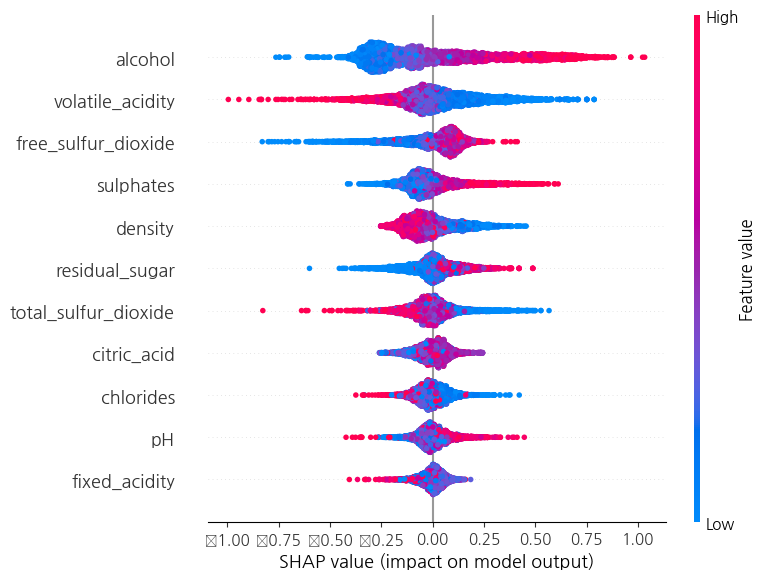

In [46]:
# SHAP 값 시각화
# 1. 요약 플롯 (Summary Plot) - 전체 특성의 중요도를 보여줌
shap.summary_plot(shap_values, train_df[feature_cols])

In [47]:
# SHAP 값의 절대값 평균을 기반으로 피쳐 중요도 계산
feature_importance = np.mean(np.abs(shap_values.values), axis=0)

# 피쳐 이름과 함께 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
})

# 중요도에 따라 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 데이터프레임 출력
# importance_df
print(importance_df.to_string(index=False))

             Feature  Importance
             alcohol    0.250609
    volatile_acidity    0.153002
 free_sulfur_dioxide    0.112297
           sulphates    0.095509
             density    0.092933
      residual_sugar    0.082921
total_sulfur_dioxide    0.079486
         citric_acid    0.057301
           chlorides    0.055799
                  pH    0.054898
       fixed_acidity    0.041200


In [48]:
# 만들고자 하는 폴더 경로
folder_path = 'artifacts/shap_images'
utils.create_clean_folder(folder_path)

In [49]:
# SHAP 값 시각화
plt.figure(figsize=(10, 8))  # 크기를 설정 (10인치 너비, 8인치 높이)

# 1. 요약 플롯 (Summary Plot) - 전체 특성의 중요도를 보여줌
shap.summary_plot(shap_values, train_df[feature_cols], show=False)
# 이미지 저장
plt.savefig(f"{folder_path}/shap_summary_plot.png", dpi=100, bbox_inches='tight')

# 차트를 닫아 메모리 관리
plt.close()

In [50]:
%%time
# figure max open warning 제한을 높임
mpl.rcParams['figure.max_open_warning'] = 100  # 100으로 설정 (원하는 만큼 설정 가능)

for index, col_name in enumerate(important_feature_cols):
    # 3. 특성의 단일 영향도 시각화 (Dependence Plot)
    plt.figure(figsize=(8, 8))  # 인치 단위로 크기 설정 (800x800 픽셀)
    shap.dependence_plot(col_name, shap_values.values, train_df[feature_cols], show=False)
    # 이미지 저장
    plt.savefig(f"{folder_path}/fig_{col_name}.png", dpi=100, bbox_inches='tight')  # dpi=100 설정으로 크기 조정
    # 플롯 닫기
    plt.close()

CPU times: user 5.19 s, sys: 586 ms, total: 5.78 s
Wall time: 6.01 s


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

# 모델 및 설정값 저장

In [51]:
# 만들고자 하는 폴더 경로
folder_path = 'artifacts/model'
utils.create_clean_folder(folder_path)

In [52]:
# 모델 저장
joblib.dump(model, f'{folder_path}/model.pkl')

['artifacts/model/model.pkl']

In [53]:
final_importance_df.to_csv(f'{folder_path}/feature_importance.csv', index=False)

In [54]:
metric_df = pd.DataFrame(metric_res)
metric_df

,train_metrics,valid_metric,test_metric
MSE,0.094917,0.426082,0.374782
RMSE,0.308086,0.652749,0.612195
MAE,0.228928,0.474210,0.448058
R2 Score,0.873958,0.489451,0.512099
MSLE,0.002265,0.009457,0.008654
Explained Variance,0.873958,0.490310,0.515695
Median AE,0.172954,0.344093,0.328384


In [55]:
metric_df.to_csv(f'{folder_path}/metric.csv', index=False)

In [56]:
logger.info(metric_df)

2024-11-07 06:45:57,573 - INFO
                    train_metrics  valid_metric  test_metric
MSE                      0.094917      0.426082     0.374782
RMSE                     0.308086      0.652749     0.612195
MAE                      0.228928      0.474210     0.448058
R2 Score                 0.873958      0.489451     0.512099
MSLE                     0.002265      0.009457     0.008654
Explained Variance       0.873958      0.490310     0.515695
Median AE                0.172954      0.344093     0.328384


In [57]:
# 파일 복사
shutil.copy(config_file, folder_path)
shutil.copy(pickle_file, folder_path)

'artifacts/model/df.pickle'

# 이미지 파일 결과 체크

In [58]:
!ls ./artifacts

ebm_images  metric_images  model  shap_images  smooth_ebm_images


In [59]:
!ls ./artifacts/ebm_images

fig_alcohol.png      fig_fixed_acidity.png	  fig_sulphates.png
fig_chlorides.png    fig_free_sulfur_dioxide.png  fig_total_sulfur_dioxide.png
fig_citric_acid.png  fig_pH.png			  fig_volatile_acidity.png
fig_density.png      fig_residual_sugar.png


In [60]:
!ls ./artifacts/smooth_ebm_images

fig_alcohol.png      fig_fixed_acidity.png	  fig_sulphates.png
fig_chlorides.png    fig_free_sulfur_dioxide.png  fig_total_sulfur_dioxide.png
fig_citric_acid.png  fig_pH.png			  fig_volatile_acidity.png
fig_density.png      fig_residual_sugar.png


In [61]:
!ls ./artifacts/shap_images

fig_alcohol.png      fig_fixed_acidity.png	  fig_sulphates.png
fig_chlorides.png    fig_free_sulfur_dioxide.png  fig_total_sulfur_dioxide.png
fig_citric_acid.png  fig_pH.png			  fig_volatile_acidity.png
fig_density.png      fig_residual_sugar.png	  shap_summary_plot.png


In [62]:
!ls ./artifacts/metric_images

forecasting_test.png  metric.png


In [63]:
!ls ./artifacts/model

config.yml  feature_importance.csv  model.pkl
df.pickle   metric.csv		    regression_lgbm_output.ipynb
